In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import datetime as dtm
import matplotlib.pyplot as plt

from tpot import TPOTClassifier
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

C:\ProgramData\Anaconda3\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


### Prepare Dataset

In [2]:
def make_dataset(df_x, df_y, init_state=True, y_horizon_is_x=True):
    x_horizon = len(df_x.loc[df_x.index[0], df_x.columns[0]])
    if y_horizon_is_x:
        y_horizon = x_horizon
    len_x = len(df_x.columns) + 1 if init_state else 0
    len_y = 1
    X = np.array([])
    Y = np.array([])
    for ix in df_x.index:
        x = np.empty([len_x, x_horizon])
        y = np.empty([len_y, y_horizon])
        for i, c in enumerate(df_x.columns):
            x[i] = np.array(df_x.loc[ix, c])
        if init_state:
            i += 1
            x[i] = df_y[ix]
        # Add y at end
        y[0] = df_y[ix+pd.DateOffset(hours=1):ix+pd.DateOffset(hours=y_horizon)].values
        # Reshape (rows, cols)
        x = x.T.reshape(1, x.T.shape[0], x.T.shape[1])
        y = y.T.reshape(1, y.T.shape[0], y.T.shape[1])
        #x = x.reshape(1, x.shape[0], x.shape[1])
        #y = y.reshape(1, y.shape[0], y.shape[1])
        if not np.isnan(x).any() and not np.isnan(y).any():
            if X.size == 0:
                X = x
                Y = y
            else:
                X = np.append(X, x, axis=0)
                Y = np.append(Y, y, axis=0)
    return {'x': X, 'y': Y}

In [3]:
# Load Weather Forecast (X)
wf = pd.read_json('./old_cyder/weather_forecast_dataframe_updated.json')
wf.index = pd.to_datetime(wf.index)
del wf['timeIndex']
#wf['month'] = wf.index.month
#wf['weekday'] = wf.index.weekday

# Load PV data to be predicted (Y)
pv = pd.read_csv('./old_cyder/PV_data_cleanedup_20180904.csv', index_col=[0])
pv.index = pd.to_datetime(pv.index)
pv = pv['PV1_activePower_computed']
pv = pv.resample('1H').mean()
# Remove noise
pv[(pv>0) & (pv.shift(1)==0) & (pv.shift(-1)==0)] = 0

# Make combined numpy array
data = make_dataset(wf, pv, init_state=True)

In [4]:
data['x'].shape, data['y'].shape

((842, 23, 4), (842, 23, 1))

### Evalaute Model

In [5]:
def rmse(x, y):
    return np.sqrt(mean_squared_error(x, y))

In [6]:
# Scale Data
data_scaled = {}
scaler = {}
for k, v in data.items():
    scaler[k] = {}
    data_scaled[k] = np.copy(data[k])
    for c in range(v.shape[2]):
        scaler[k][c] = {'fun': MinMaxScaler((0, 1))}
        scaler[k][c]['param'] = scaler[k][c]['fun'].fit(v[:,:,c].reshape(v.shape[0]*v.shape[1],1))
        data_scaled[k][:,:,c] = scaler[k][c]['fun'].transform(v[:,:,c].reshape(v.shape[0]*v.shape[1],1)).reshape(v.shape[0],v.shape[1])
        print(scaler[k][c]['fun'].data_max_)
        
# Scale Back
def scale_back(v, scaler, horizon=23):
    v = np.copy(v)
    v = v.reshape(v.shape[0], horizon, int(v.shape[1]/horizon))
    for c in range(v.shape[2]):
        #v[:,c].reshape(v.shape[0]*v.shape[1],1)
        #scaler[c]['fun'].transform(v[:,:,c].reshape(v.shape[0]*v.shape[1],1)).reshape(v.shape[0],v.shape[1])
        v[:,:,c] = scaler[c]['fun'].inverse_transform(v[:,:,c].reshape(v.shape[0]*v.shape[1],1)).reshape(v.shape[0],v.shape[1])
    return v
        
# Split Data
data_flat = {k:v.reshape(v.shape[0], v.shape[1]*v.shape[2]) for k,v in data_scaled.items()}
x_train, x_test, y_train, y_test = train_test_split(data_flat['x'], data_flat['y'], random_state=42)


[26.7]
[100.]
[966.9192092]
[2701.5415499]
[2701.5415499]


In [7]:
cfg = {}
cfg['solver'] = 'adam'
cfg['hidden_layer_sizes'] = (10, 10)
#cfg['activation'] = 'relu'
#cfg['activation'] = 'logistic'
cfg['activation'] = 'tanh'
cfg['max_iter'] = 5000
cfg['validation_fraction'] = 0.1
cfg['learning_rate'] = 'constant'
cfg['tol'] = 1e-6
model = MLPRegressor(**cfg)
res = model.fit(x_train, y_train)
print('Iterations: {}'.format(res.n_iter_))
print('Training: {:.3f}; Testing: {:.3f}; RMSE: {:.1f}'.format( \
    res.score(x_train, y_train), res.score(x_test, y_test), \
    rmse(scale_back(model.predict(x_test).reshape(y_test.shape+(1,)), scaler['y']).reshape(y_test.shape),
         scale_back(y_test.reshape(y_test.shape+(1,)), scaler['y']).reshape(y_test.shape))))   

Iterations: 584
Training: 0.928; Testing: 0.917; RMSE: 261.8


In [8]:
# tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, random_state=42)
# tpot.fit(x_train, y_train)
# print(tpot.score(x_test, y_test))

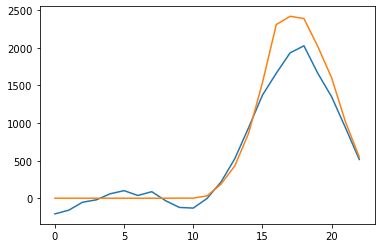

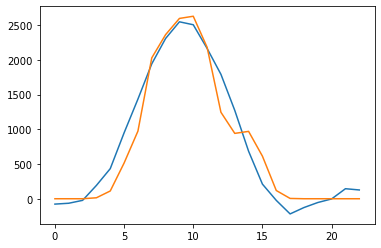

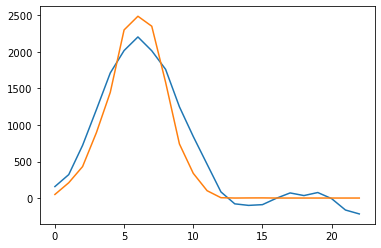

In [9]:
for i in range(3):
    plt.plot(scale_back(model.predict(x_test).reshape(y_test.shape+(1,)), scaler['y'])[i])
    plt.plot(scale_back(y_test.reshape(y_test.shape+(1,)), scaler['y'])[i])
    plt.show()

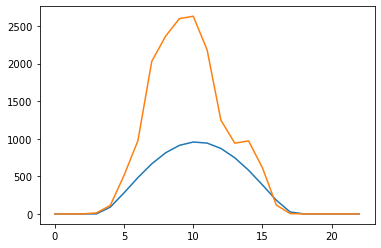

In [10]:
plt.plot(scale_back(x_test, scaler['x'])[1,:,2])
plt.plot(scale_back(y_test, scaler['y'])[1,:,0])

### SARIMA models

In [11]:
#from old_cyder.Forecast_functions_V2 import Forecasting
#from old_cyder.PV_forecast_function_notebook import getPVforecast_v4

In [12]:
# obsDf = pv.loc['2018-07-21':'2018-07-23'].copy(deep=True)
# wfDf = wf.loc['2018-07-23 23:00'].copy(deep=True)

# predHor=96
# timeStep = (obsDf.index[1]-obsDf.index[0]).seconds/60
# timeStepCtrl = 5
# tsPeriod = 96
# retrainFlag=False
# resample2CtrlStep = False

# forecast5min, \
# forecast15min, \
# forecastSARIMA, \
# forecastNN = getPVforecast_v4(obsDf, \
#                                     wfDf, \
#                                     self.models, \
#                                     predHor, \
#                                     timeStep, \
#                                     timeStepCtrl, \
#                                     tsPeriod, \
#                                     retrainFlag, \
#                                     resample2CtrlStep)

# predfinal = predHor - 4
# new_ix = [obsDf.index[-1] + pd.DateOffset(minutes=timeStep*(s+1)) for s in range(predfinal)]
# forecast = pd.DataFrame({ \
#                               'final':forecast15min.reshape(predfinal), \
#                               'sarima':forecastSARIMA.reshape(predfinal), \
#                               'nn':forecastNN.reshape(predfinal)}, index=new_ix)